In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn import metrics, model_selection
import glob
import seaborn as sns

%matplotlib inline

import os
print(os.listdir("."))

/home/lazukav/anaconda3/lib/python3.5/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


['titanic_submit.ipynb', '.ipynb_checkpoints', 'model2.csv', 'test.csv', 'train.csv', 'titanic_submit-old_copy.ipynb', 'model4.csv', 'model3.csv', 'model1.csv', 'model5.csv']


In [2]:
def data_split(data):
#     data = data.sample(frac=1)
    Y = data['Survived']
    X = data.drop(['Survived'], axis=1)
    return X, Y

# def load_data(train_path='train.csv', test_path='test.csv', test_labels='gender_submission.csv'):
def load_data(train_path='train.csv', test_path='test.csv'):
    train = pd.DataFrame.from_csv(train_path, index_col=0)
    test_X = pd.DataFrame.from_csv(test_path, index_col=0)
#     test_Y.drop([0], inplace=True)
#     test_Y = pd.Series.from_csv(test_labels)
    train_X, train_Y = data_split(train)
              
#     print(train.head())
#     print(test_Y.head())
    return train_X, train_Y, test_X

In [3]:
train_X, train_Y, test_X = load_data()
print(train_X.shape, train_Y.shape)
print(test_X.shape)

(891, 10) (891,)
(418, 10)


/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':
/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # Remove the CWD from sys.path while we load stuff.


# EDA

In [4]:
def data_stat(data):
    print("Describe: ", data.describe(), sep='\n')
    print("Correlation: ", data.corr(), sep='\n')
    print("#NaN: ", data.isna().sum(), sep='\n')

In [5]:
data_stat(train_X)

Describe: 
           Pclass         Age       SibSp       Parch        Fare
count  891.000000  714.000000  891.000000  891.000000  891.000000
mean     2.308642   29.699118    0.523008    0.381594   32.204208
std      0.836071   14.526497    1.102743    0.806057   49.693429
min      1.000000    0.420000    0.000000    0.000000    0.000000
25%      2.000000   20.125000    0.000000    0.000000    7.910400
50%      3.000000   28.000000    0.000000    0.000000   14.454200
75%      3.000000   38.000000    1.000000    0.000000   31.000000
max      3.000000   80.000000    8.000000    6.000000  512.329200
Correlation: 
          Pclass       Age     SibSp     Parch      Fare
Pclass  1.000000 -0.369226  0.083081  0.018443 -0.549500
Age    -0.369226  1.000000 -0.308247 -0.189119  0.096067
SibSp   0.083081 -0.308247  1.000000  0.414838  0.159651
Parch   0.018443 -0.189119  0.414838  1.000000  0.216225
Fare   -0.549500  0.096067  0.159651  0.216225  1.000000
#NaN: 
Pclass        0
Name          0


/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


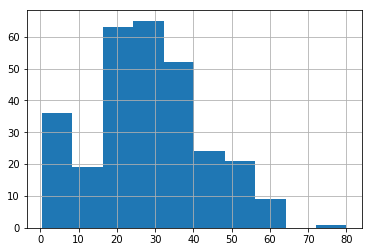

In [6]:
train = pd.DataFrame.from_csv('train.csv', index_col=0)
train.Age[train.Survived==1].hist()
# train.Age.hist()
# train[train.Age.isna()]

In [7]:
# train['Relatives'] = train['SibSp'] + train['Parch']
# train.corr()
# train = pd.get_dummies(train, columns=['Pclass'])
# train.head()
# test.isna().sum()
# train.drop(['SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1, inplace=True)

# MODEL 1 params=[gender]

In [8]:
# train_X, train_Y, test_X = load_data()

def proc_data(data):
    sex_mapping = {
        'male': 1,
        'female': 0
    }
    data['Sex'] = data['Sex'].map(sex_mapping)
    male_mean_age = data[data["Sex"]==1]["Age"].mean()
    female_mean_age = data[data["Sex"]==0]["Age"].mean()
    
    data.loc[ (data["Sex"]==1) & (data["Age"].isnull()), "Age"] = male_mean_age
    data.loc[ (data["Sex"]==0) & (data["Age"].isnull()), "Age"] = female_mean_age
    data.drop(['Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1, inplace=True)
    data = pd.get_dummies(data, columns=['Pclass'])
    data['Relatives'] = data['SibSp'] + data['Parch']

    return data

train_X = proc_data(train_X)
test_X = proc_data(test_X)

In [9]:
train_X.columns

Index(['Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Relatives'],
      dtype='object')

In [10]:
sex = tf.feature_column.numeric_column('Sex')
age = tf.feature_column.numeric_column('Age')
age_bucket = tf.feature_column.bucketized_column(age, [8, 16, 21, 32, 40, 55])
sibsp = tf.feature_column.numeric_column('SibSp')
parch = tf.feature_column.numeric_column('Parch')
pclass1 = tf.feature_column.numeric_column('Pclass_1')
pclass2 = tf.feature_column.numeric_column('Pclass_2')
pclass3 = tf.feature_column.numeric_column('Pclass_3')
relatives = tf.feature_column.numeric_column('Relatives')

# sex_feature = tf.feature_column.categorical_column_with_vocabulary_list(
#     'Sex',['female','male'])


cols = [sex]

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_X, train_Y, test_size=0.2, shuffle=None)

# Full estimators

In [12]:
def train_classification_model(
    learning_rate,
    steps,
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    cols,
    m_dir,
    periods):

    steps_per_period = steps / periods  

    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        shuffle=True,
    )

    ptraining_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        num_epochs=1,
        shuffle=False,
    )

    validation_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        num_epochs=1,
        shuffle=False 
    )

    # Create a LinearClassifier object.
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=cols,
        n_classes=2,
        optimizer=my_optimizer,
        hidden_units=[64, 128, 64],
        model_dir=m_dir
    )

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        classifier.evaluate(input_fn=validation_input_fn)
        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=ptraining_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 2)

        validation_predictions = list(classifier.predict(input_fn=validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 2)    
        print("Hey")
        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(y_train, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(y_test, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])


    accuracy = metrics.accuracy_score(y_test, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(y_test, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

# Model1 (0.76555)

In [13]:
cols = [sex]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_experimental_distribute': None, '_tf_random_seed': None, '_evaluation_master': '', '_num_worker_replicas': 1, '_model_dir': '/tmp/model1', '_task_type': 'worker', '_train_distribute': None, '_num_ps_replicas': 0, '_device_fn': None, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_service': None, '_master': '', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8441b0e4e0>, '_global_id_in_cluster': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_secs': 600,

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-72
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Hey
  period 01 : 7.72
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-72
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 72 into /tmp/model1/model.ckpt.
INFO:tensorflow:loss = 63.65213, step = 73
INFO:tensorflow:Saving checkpoints for 78 into /tmp/model1/model.ckpt.
INFO:tensorflow:Loss for final step: 34.300358.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-15T18:18:47Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-78
INFO:tensorfl

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-96
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-96
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Hey
  period 05 : 7.72
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-96
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 96 into /tmp/model1/model.ckpt.
INFO:tensorflow:loss = 58.766922, step = 97
INFO:tensorflow:Saving checkpoints for 102 into /tmp/model1/model.ckpt.
INFO:tensorflow:Loss for final step:

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 120: /tmp/model1/model.ckpt-120
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Hey
  period 09 : 7.72
Model training finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Final accuracy (on validation data): 0.78


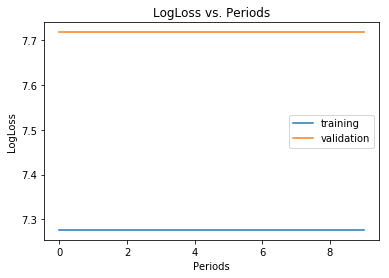

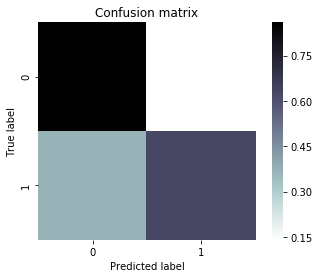

In [14]:
model1 = train_classification_model(
    learning_rate=0.01,
    steps=100,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    m_dir='/tmp/model1',
    periods=10)

In [15]:
scores1 = model1.predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=test_X,
                                                                      num_epochs=1,
                                                                      shuffle=False))

res = []
for i, p in enumerate(scores1):
#     print(i + 892, p['class_ids'][0])
    res.append([i + 892, p['class_ids'][0]])   

#to df then to series and save to file
result = pd.DataFrame(res, columns=['PassengerId', 'Survived'])
result.to_csv('model1.csv', index=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model1/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


# Model 2 (0.76555)

In [16]:
cols = [sex, pclass1, pclass2, pclass3]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_experimental_distribute': None, '_tf_random_seed': None, '_evaluation_master': '', '_num_worker_replicas': 1, '_model_dir': '/tmp/model2', '_task_type': 'worker', '_train_distribute': None, '_num_ps_replicas': 0, '_device_fn': None, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_service': None, '_master': '', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f839ffa9b70>, '_global_id_in_cluster': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_secs': 600, '_eval_distribute': None, '_log_step_count_steps': 100, '_save_checkpoints_steps': None}
Training model...
LogLoss error (on validation data):
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Cre

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-84
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-15-18:19:40
INFO:tensorflow:Saving dict for global step 84: accuracy = 0.7765363, accuracy_baseline = 0.6368715, auc = 0.78225374, auc_precision_recall = 0.76326644, average_loss = 0.50136465, global_step = 84, label/mean = 0.36312848, loss = 44.872135, precision = 0.71929824, prediction/mean = 0.3600255, recall = 0.63076925
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 84: /tmp/model2/model.ckpt-84
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-84
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tens

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-15T18:19:58Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-108
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-15-18:19:59
INFO:tensorflow:Saving dict for global step 108: accuracy = 0.7765363, accuracy_baseline = 0.6368715, auc = 0.78225374, auc_precision_recall = 0.76326644, average_loss = 0.50806975, global_step = 108, label/mean = 0.36312848, loss = 45.47224, precision = 0.71929824, prediction/mean = 0.37538615, recall = 0.63076925
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 108: /tmp/model2/model.ckpt-108
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-108
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done 

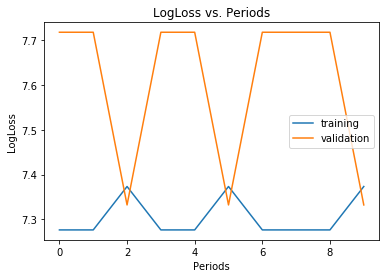

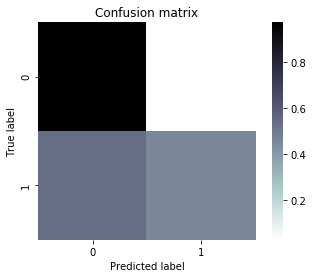

In [17]:
model2 = train_classification_model(
    learning_rate=0.01,
    steps=100,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    m_dir='/tmp/model2',
    periods=10)

In [18]:
scores2 = model2.predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=test_X,
                                                                      num_epochs=1,
                                                                      shuffle=False))

res = []
for i, p in enumerate(scores2):
#     print(i + 892, p['class_ids'][0])
    res.append([i + 892, p['class_ids'][0]])   

#to df then to series and save to file
result = pd.DataFrame(res, columns=['PassengerId', 'Survived'])
result.to_csv('model2.csv', index=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model2/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


# Model 3 (0.73205)

In [19]:
cols = [sex, pclass1, pclass2, pclass3, age_bucket]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_experimental_distribute': None, '_tf_random_seed': None, '_evaluation_master': '', '_num_worker_replicas': 1, '_model_dir': '/tmp/model3', '_task_type': 'worker', '_train_distribute': None, '_num_ps_replicas': 0, '_device_fn': None, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_service': None, '_master': '', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f84401e23c8>, '_global_id_in_cluster': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_secs': 600, '_eval_distribute': None, '_log_step_count_steps': 100, '_save_checkpoints_steps': None}
Training model...
LogLoss error (on validation data):
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tenso

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-15T18:20:30Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-84
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-15-18:20:30
INFO:tensorflow:Saving dict for global step 84: accuracy = 0.7877095, accuracy_baseline = 0.6368715, auc = 0.7962213, auc_precision_recall = 0.7816671, average_loss = 0.4915361, global_step = 84, label/mean = 0.36312848, loss = 43.99248, precision = 0.71428573, prediction/mean = 0.35621437, recall = 0.6923077
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 84: /tmp/model3/model.ckpt-84
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-84
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running lo

INFO:tensorflow:Saving checkpoints for 108 into /tmp/model3/model.ckpt.
INFO:tensorflow:Loss for final step: 28.273952.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-15T18:20:50Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-108
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-15-18:20:50
INFO:tensorflow:Saving dict for global step 108: accuracy = 0.7932961, accuracy_baseline = 0.6368715, auc = 0.7929149, auc_precision_recall = 0.78289485, average_loss = 0.4864196, global_step = 108, label/mean = 0.36312848, loss = 43.534554, precision = 0.73333335, prediction/mean = 0.3664762, recall = 0.6769231
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 108: /tmp/model3/model.ckpt-108
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow

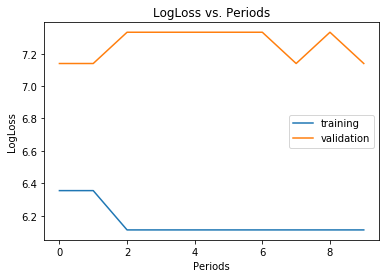

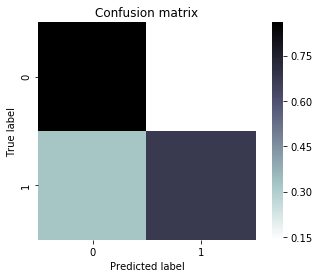

In [20]:
model3 = train_classification_model(
    learning_rate=0.01,
    steps=100,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    m_dir='/tmp/model3',
    periods=10)

In [21]:
scores3 = model3.predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=test_X,
                                                                      num_epochs=1,
                                                                      shuffle=False))

res = []
for i, p in enumerate(scores3):
#     print(i + 892, p['class_ids'][0])
    res.append([i + 892, p['class_ids'][0]])   

#to df then to series and save to file
result = pd.DataFrame(res, columns=['PassengerId', 'Survived'])
result.to_csv('model3.csv', index=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model3/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


# MODEL 4 (0.74162)

In [22]:
cols = [sex, pclass1, pclass2, pclass3, age_bucket, relatives]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_experimental_distribute': None, '_tf_random_seed': None, '_evaluation_master': '', '_num_worker_replicas': 1, '_model_dir': '/tmp/model4', '_task_type': 'worker', '_train_distribute': None, '_num_ps_replicas': 0, '_device_fn': None, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_service': None, '_master': '', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8394b779b0>, '_global_id_in_cluster': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_secs': 600, '_eval_distribute': None, '_log_step_count_steps': 100, '_save_checkpoints_steps': None}
Training model...
LogLoss error (on validation data):
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Cre

INFO:tensorflow:Restoring parameters from /tmp/model4/model.ckpt-84
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-15-18:21:20
INFO:tensorflow:Saving dict for global step 84: accuracy = 0.8156425, accuracy_baseline = 0.6368715, auc = 0.8142375, auc_precision_recall = 0.80374396, average_loss = 0.4683623, global_step = 84, label/mean = 0.36312848, loss = 41.918427, precision = 0.7758621, prediction/mean = 0.35016426, recall = 0.6923077
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 84: /tmp/model4/model.ckpt-84
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model4/model.ckpt-84
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorf

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-15T18:21:40Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model4/model.ckpt-108
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-15-18:21:41
INFO:tensorflow:Saving dict for global step 108: accuracy = 0.7709497, accuracy_baseline = 0.6368715, auc = 0.8199055, auc_precision_recall = 0.79912424, average_loss = 0.48628256, global_step = 108, label/mean = 0.36312848, loss = 43.52229, precision = 0.6621622, prediction/mean = 0.4132765, recall = 0.75384617
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 108: /tmp/model4/model.ckpt-108
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model4/model.ckpt-108
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done run

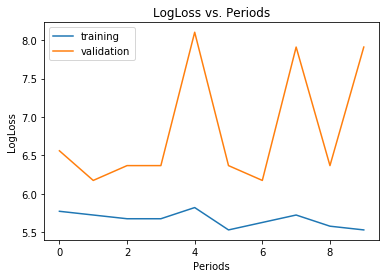

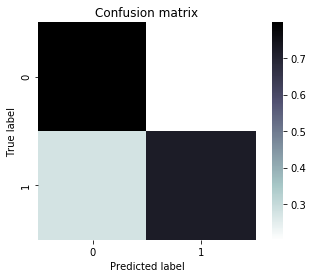

In [23]:
model4 = train_classification_model(
    learning_rate=0.01,
    steps=100,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    m_dir='/tmp/model4',
    periods=10)

In [24]:
scores4 = model4.predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=test_X,
                                                                      num_epochs=1,
                                                                      shuffle=False))

res = []
for i, p in enumerate(scores4):
#     print(i + 892, p['class_ids'][0])
    res.append([i + 892, p['class_ids'][0]])   

#to df then to series and save to file
result = pd.DataFrame(res, columns=['PassengerId', 'Survived'])
result.to_csv('model4.csv', index=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model4/model.ckpt-120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


# Boosted trees (0.62679)

In [25]:
def train_classification_model(
    learning_rate,
    steps,
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    cols,
    m_dir,
    periods):

    steps_per_period = steps / periods  

    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        shuffle=True,
    )

    ptraining_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        num_epochs=1,
        shuffle=False,
    )

    validation_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        num_epochs=1,
        shuffle=False 
    )

    classifier = tf.estimator.BoostedTreesClassifier(
        feature_columns=cols,
        n_batches_per_layer=batch_size,
        n_classes=2,
        n_trees=20,
        model_dir=m_dir
    )

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        classifier.evaluate(input_fn=validation_input_fn)
        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=ptraining_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 2)

        validation_predictions = list(classifier.predict(input_fn=validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 2)    
        print("Hey")
        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(y_train, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(y_test, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])


    accuracy = metrics.accuracy_score(y_test, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(y_test, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_experimental_distribute': None, '_tf_random_seed': None, '_evaluation_master': '', '_num_worker_replicas': 1, '_model_dir': '/tmp/model5', '_task_type': 'worker', '_train_distribute': None, '_num_ps_replicas': 0, '_device_fn': None, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_protocol': None, '_service': None, '_master': '', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f83132b6fd0>, '_global_id_in_cluster': 0, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_secs': 600, '_eval_distribute': None, '_log_step_count_steps': 100, '_save_checkpoints_steps': None}
Training model...
LogLoss error (on validation data):
INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-15T18:22:03Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-15-18:22:04
INFO:tensorflow:Saving dict for global step 0: accuracy = 0.6368715, accuracy_baseline = 0.6368715, auc = 0.5, auc_precision_recall = 0.6815642, average_loss = 0.6931473, global_step = 0, label/mean = 0.36312848, loss = 0.69314724, precision = 0.0, prediction/mean = 0.5, recall = 0.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 0: /tmp/model5/model.ckpt-0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:C

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 0: /tmp/model5/model.ckpt-0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Hey
  period 05 : 12.54
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match 

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving checkpoints for 0 into /tmp/model5/model.ckpt.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:loss = 0.6931473, step = 0
INFO:tensorflow:Loss for final step: 0.6931472.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-15T18:22:26Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring paramet

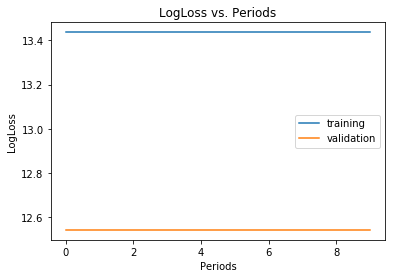

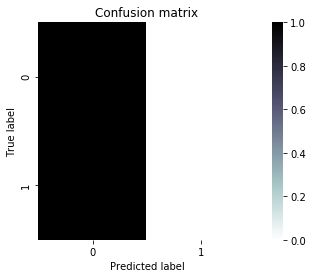

In [26]:
model5 = train_classification_model(
    learning_rate=0.01,
    steps=100,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    m_dir='/tmp/model5',
    periods=10)

In [27]:
scores5 = model5.predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=test_X,
                                                                      num_epochs=1,
                                                                      shuffle=False))

res = []
for i, p in enumerate(scores5):
#     print(i + 892, p['class_ids'][0])
    res.append([i + 892, p['class_ids'][0]])   

#to df then to series and save to file
result = pd.DataFrame(res, columns=['PassengerId', 'Survived'])
result.to_csv('model5.csv', index=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
